This notebook showcases how the data for pytorch captioning tutorial was originally obtained.

Running this script is not necessary to complete the basic assignment as __you will be given preprocessed data__ produced by this notebook. The script itself takes hours

However, if one wants to implement e.g. attentive captioning with attention casted into earlier layers in the network OR try a different network architecture, one is invited to change this code at will. 
GPU(s), high-speed internet and ~50G of disc space are recommended.

In [1]:
# Obtaining the data:
# download stuff from http://cocodataset.org/#download
!curl http://images.cocodataset.org/zips/train2017.zip > train2017.zip
!curl http://images.cocodataset.org/zips/val2017.zip > val2017.zip
!curl http://images.cocodataset.org/annotations/annotations_trainval2017.zip > annotations_trainval2017.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.0G  100 18.0G    0     0  24.5M      0  0:12:32  0:12:32 --:--:-- 24.6MG   12 2308M    0     0  24.0M      0  0:12:47  0:01:36  0:11:11 24.4M0G   19 3650M    0     0  24.1M      0  0:12:42  0:02:31  0:10:11 24.4MM    0     0  24.1M      0  0:12:42  0:02:42  0:10:00 24.3M   34 6322M    0     0  24.2M      0  0:12:41  0:04:21  0:08:20 23.8M12:40  0:05:18  0:07:22 24.7M  0:06:41 24.6M 49 9092M    0     0  24.3M      0  0:12:38  0:06:14  0:06:24 24.7M1 9488M    0     0  24.3M      0  0:12:38  0:06:30  0:06:08 24.7M5:04 24.7M.0G   61 11.0G    0     0  24.3M      0  0:12:36  0:07:43  0:04:53 24.8M 75 13.5G    0     0  24.4M      0  0:12:34  0:09:27  0:03:07 24.6M   79 14.4G    0     0  24.4M      0  0:12:33  0:10:03  0:02:30 24.7M  0:10:11  0:02:22 24.6MG   83 15.0G    0     0  24.4M      0  0:12:33  0:10:30  0:02:03 24.6M0:12:33

In [8]:
!unzip annotations_trainval2017.zip
!unzip train2017.zip > log
!unzip val2017.zip > log

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [9]:
# sanity check
!du -h --max-depth=1 .

724K	./.ipynb_checkpoints
796M	./annotations
957M	./data
19G	./train2017
788M	./val2017
40G	.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
%env CUDA_VISIBLE_DEVICES=1,2
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

env: CUDA_VISIBLE_DEVICES=1,2


In [15]:
# you may need to !pip install pycocotools
from torchvision.datasets import coco
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])
coco_train = coco.CocoCaptions("./train2017/", "./annotations/captions_train2017.json", transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=coco_train, batch_size=32, shuffle=False, num_workers=4)

loading annotations into memory...
Done (t=2.08s)
creating index...
index created!


In [16]:
from torchvision.models.inception import Inception3
from warnings import warn
class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x

In [17]:
from torch.utils.model_zoo import load_url
model= BeheadedInception3(transform_input=True)

inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
model.load_state_dict(load_url(inception_url))

model = nn.DataParallel(model.train(False).cuda())

/usr/local/lib/python3.6/dist-packages/torchvision/models/inception.py:77: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


# Sanity check

Test-run NN over one batch. NN labels shouldn't be completely absurd.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """


NN shapes
before_pool: (32, 2048, 8, 8)
after_pool: (32, 2048)
logits: (32, 1000)
# 0


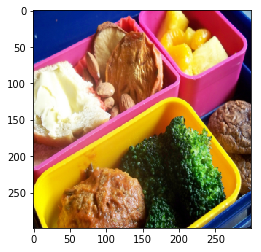

Captions
('Closeup of bins of food that include broccoli and bread.', 'A meal is presented in brightly colored plastic trays.', 'there are containers filled with different kinds of foods', 'Colorful dishes holding meat, vegetables, fruit, and bread.', 'A bunch of trays that have different food.')
NN classes
['bell pepper', 'cauliflower', 'mixing bowl', 'cucumber, cuke', 'grocery store, grocery, food market, market']
# 3


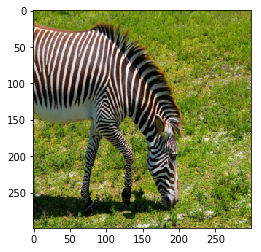

Captions
('A zebra grazing on lush green grass in a field.', 'Zebra reaching its head down to ground where grass is. ', 'The zebra is eating grass in the sun.', 'A lone zebra grazing in some green grass.', 'a Zebra grazing on grass in a green open field.')
NN classes
['zebra', 'hartebeest', 'ostrich, Struthio camelus', 'prairie chicken, prairie grouse, prairie fowl', 'African elephant, Loxodonta africana']
# 6


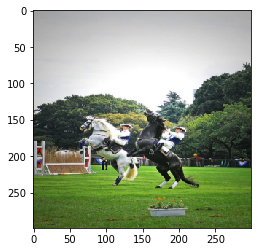

Captions
('A couple of men riding horses on top of a green field.', 'two horses and their riders on some grass', 'Two men are on horses that are reared back.', 'A pair of horses performing tricks in a field. ', 'Two costumed horse riders make their horses stand on their hind legs.')
NN classes
['shield, buckler', 'EntleBucher', 'Greater Swiss Mountain dog', 'cannon', 'parachute, chute']
# 9


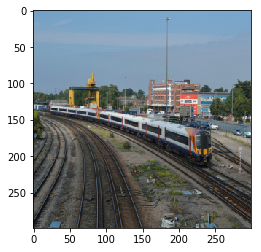

Captions
('A train coming to a stop on the tracks out side.', 'The very long train is travelling down the tracks.', 'A passenger train glides around a curve on the outer track.', 'A train coming down the tracks in the city.', 'A train engine carrying many carts down a track.')
NN classes
['steam locomotive', 'freight car', 'electric locomotive', 'passenger car, coach, carriage', 'traffic light, traffic signal, stoplight']


In [18]:
img_batch, capt_batch = next(iter(data_loader))

# captions batch is transposed in our version. Check if the same is true for yours
capt_batch = list(zip(*capt_batch))
img_batch = Variable(img_batch, volatile=True)
vec_batch_for_attn, vec_batch, logits_batch  = [var.cpu().data.numpy() for var in model(img_batch)]

print("NN shapes")
print('before_pool:', np.shape(vec_batch_for_attn))
print('after_pool:', np.shape(vec_batch))
print('logits:', np.shape(logits_batch))


# class labels
import requests
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key): value for (key, value) in requests.get(LABELS_URL).json().items()}

for i in range(0, 10, 3):
    print("#", i)
    plt.imshow(img_batch[i].data.cpu().numpy().transpose([1,2,0]))
    plt.show()
    print('Captions')
    print(capt_batch[i])

    top_ix = (-logits_batch[i]).argsort()
    print('NN classes')
    print(list(map(labels.get, top_ix[:5])))

# Actually transforming data

Note: this part may consume a lot of RAM. If your's a bit limited:
* Do not store vectors that you don't need (e.g. vectors_before_pool if no attention)
* Save everything on a disk every K iterations and free the memory.
    * They ya'll have to manually read it.

In [19]:
from tqdm import tqdm
vectors_before_pool, vectors, logits, captions = [], [], [], []
for img_batch, capt_batch in tqdm(data_loader):
    capt_batch = list(zip(*capt_batch))
    img_batch = Variable(img_batch, volatile=True)
    vec_batch_for_attn, vec_batch, logits_batch  = [var.cpu().data.numpy() for var in model(img_batch)]
    
    
    logits.extend([vec for vec in logits_batch])
    captions.extend(capt_batch)
    vectors.extend([vec for vec in vec_batch])
    
    ## WARNING! If you're low on ram, comment this line.
    vectors_before_pool.extend([vec for vec in vec_batch_for_attn])
    

  0%|          | 0/3697 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """
  0%|          | 13/3697 [00:10<1:04:54,  1.06s/it]

RuntimeError: Caught RuntimeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/collate.py", line 84, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/collate.py", line 84, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/collate.py", line 82, in default_collate
    raise RuntimeError('each element in list of batch should be of equal size')
RuntimeError: each element in list of batch should be of equal size


In [ ]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

captions_tokenized = [[' '.join(filter(len, tokenizer.tokenize(cap.lower()))) 
                           for cap in img_captions]
                                for img_captions in tqdm(captions)]

In [ ]:
i = 123
print("Original:\n%s\n\n" % '\n'.join(captions[i]))
print("Tokenized:\n%s\n\n"% '\n'.join(captions_tokenized[i]))

# Save everything
May take a couple of minutes depending on hdd/sdd speed.

In [ ]:
!mkdir data
np.save("./data/image_codes.npy", np.asarray(vectors))
np.save("./data/image_codes_for_attn.npy", np.asarray(vectors_before_pool))
np.save('./data/image_logits.npy', np.asarray(logits))

import json
with open('./data/captions.json', 'w') as f_cap:
    json.dump(captions, f_cap)
with open('./data/captions_tokenized.json', 'w') as f_cap:
    json.dump(captions_tokenized, f_cap)

In [ ]:
# sanity check
!du -h --max-depth=1 .
!ls -lht data